## Naive Bayes for Spam Classification

In this section we will build a spam classificator using Naive Bayes probabilistic ML technique.

**Tip**: Remember, the first thing you will do when you receive some problem is transform it from business problem to ML problem. 
Example: Filter Spam >>> Take raw emails and pre-process text data. Then train a ML model that classifies the email as either spam or not-spam.

In ML we commonly have two types of problems:

* **Regressions**: You need to predict a number (time, value, amount etc.) 

* **Classification:** You need to classify something (Cancer or Not Cancer, Spam or Not Spam etc.)

For e-mail classification we have an additional challenge! We will need to adapt the body of our e-mail (text) to numbers (understandable for our algorithm).

## Naive Bayes Classifier

The main good attributes of this model are Simplicity and Speed! Spam classification and Weather forecasting are classic applications.

**How it works:** To make a decision the naive bayes classify compares probabilities (the likelihood of some event). Translating to our problem, the algorithm will calculate the probability to be or not to be spam. In addition, we will have a chart with two probabilities Spam (x-axis) or Not Spam (y-axis). The 50% / 50% probability will create a straight line called **Decision Boundary**.





## A little review about probability

**1. Basic Probability**

Normally in probability problems we will have a division between a small group by a large group. Example: What is the probability to be hit by a ligthning strike? The equation is the amount of people hit by lightning strikes / total amount of lightning strikes (240.000 / 350 MM) ~ 0.07%.

In our context, What is the probability of an email being spam? Nr Spam Emails Sent / Total Nr Emails Sent >> 148bn / 269bn = 55%!!


**2. Joint Proability**

If you flip coin twice, what is the proability to get heads 2x? This is the join probability! when you have additional recurrence. The answer for our problem is 1 / 4 ~ 25%, because we have 2x 50% of chances (50% / 2). Likewise, If you establish a confusion matrix, you will see that heads / heads is only one change in four. Matematically, multiply the probability of getting heads by itself! p(A) x p(B) 

**Important**: Each time you toss a dice or flip a coin you will have the same probability! Imagine the following situation; you fliped a coin twice and both times you got head. What is the probability to get head again? 50%! The probability are independent by itself!

**3. Conditional Probability**

This is the hard topic in the probability, here we will have dependency of something to calculate the probability of another event. Given our spam email problem, a spam email is composed by a certain pattern of words and features. But, given the word 'discount' in an email, is this email a spam or not? Measures the probability of some event occur given a previous event has occured. 

For example, the weather is cloudy, what is the probability of raining today? Given that the day is cloudy, what is the probability of raining?


Mathematically:

p(Rain / Cloudy) = p(Rain and Cloudy) / p(Cloudy)

This sounds fundamental of machine learning right? learn something to aswer another thing. Knowing the move budget we can calculate the revenue, Knowing the number of rooms we can calculate the expected price.

The problem here is to calculate the upper probability, when we have dependent actions (independent like toss a dice is easy). To calculate his probability for dependent problems we will use the Bayes Theorem.



## Bayes Theorem

Given the difficult of our conditional probability, we can reshuffle our equation for an easier version. So, let's change the question for our cloud x raining problem.

Given that is raining what is the probability of being cloudy? Mathematically would be: p(Rain / Cloudy) = p(Cloudy / Rain) p(Rain) / p(Cloudy).

Let's get back to our Email Spam problem:

* p(Spam / Viagra) = p(Viagra / Spam) p(Spam) / p(Viagra)
* p(Spam / Viagra) = (65/370.000 >> Check our dataset all emails with viagra and in the spam / all spams) * 0.55% / (75/700.000 >> Google the basic prob) 

In an email we can calculate for every single word the probability of being in an ordinary spam email. We can also use NPL to make our job easier, because some words are more frequent in spam emails.

Let's give another example: given that email has the word 'free' and 'viagra'?
We will the joint probabilities of conditional probabilities like we have seen previously, because the events are independent! 

**The Naive from Naive Bayes assumes independency of each word, that's the trick in our algorithm!**

So, image an email with the following body: "Hello friend, Want free viagra?" we will calculate the joint probabilities from condition probabilities in each word of being spam and not being spam to plot in our graph!

p(Spam / Hello) * p(Spam / Want) * p(Spam / Free) * p(Spam / Viagra)

p(Normal / Hello) * p(Normal / Want) * p(Normal / Free) * p(Normal / Viagra)

We will use the **bag of words** technique: each word is looked isoletedly, removing dependency of words like (New York or Bad Idea). 



In [73]:
# Import libraries and creating constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from os import walk
from os.path import join
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup ## Library that is used for Webscrapping and RPA. It is helpful for treating HTML

# Text Pre-processing Package - NLTK 
import nltk
from nltk.stem import PorterStemmer # Cambridge University - English Language
from nltk.stem import SnowballStemmer # For other languages 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Constants for relative file path
# For Google Colaboratory you need to upload this files on the cloud (Google Drive)
# If you are using cloud storage (Google Drive) you don't need to use 'r' as a file path

RELATIVE_PATH_EXAMPLE = '/content/drive/My Drive/SpamData/01_Processing/practice_email.txt'  
SPAM_1_PATH = '/content/drive/My Drive/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = '/content/drive/My Drive/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = '/content/drive/My Drive/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = '/content/drive/My Drive/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CATEGORY = 1
HAM_CATEGORY = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = '/content/drive/My Drive/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = '/content/drive/My Drive/SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE ='/content/drive/My Drive/SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = '/content/drive/My Drive/SpamData/02_Training/test-data.txt'

WHALE_FILE = r'SpamData\01_Processing\wordcloud_resources\whale-icon.png'
THUMBS_UP_FILE= r'SpamData\01_Processing\wordcloud_resources\thumbs-up.png'
THUMBS_DOWN_FILE= r'SpamData\01_Processing\wordcloud_resources\thumbs-down.png'


## **Step 1: Reading our data from files**

Our data is structured in two folders. One contains files with spam e-mails, and the other contains files from regular emails (as known as ham). Thus, we need to create a structure to opean each file, read and save into a string or list.

Data preparation steps: 

  1. Read all e-mails and extract the e-mail body
  2. Create a pandas DataFrame with classification Spam / Not Spam for all e-mails


First let's start with some examples:

* Example 1: Reading one e-mail as a sample. (Raw data)
* Example 2: Extracting the e-mail body. (This will be the data for our model)

In [74]:
# Here is an example from an e-mail that will be part of our analysis
stream = open(RELATIVE_PATH_EXAMPLE, encoding='latin-1')
message= stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [75]:
# Extracting the email body from raw data
stream = open(RELATIVE_PATH_EXAMPLE, encoding='latin-1') # Open buffer for file reading. OBS: UTF-8 encoding by default. You can change if necessary

is_body = False
lines = []

for line in stream: # Loops through the file

    if is_body: # If is in the body let's append into our list
    
        lines.append(line)

    elif line == '\n': # In our email the body starts with a blank space 

        is_body = True
        
stream.close() # close the buffer

# Transform our list into a simple string by using 'Join'!
email_body = '\n'.join(lines) 

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

### Extra Topic: Generator functions & Yield keyword

Before we start pre-processing our e-mails (extract the information from the e-mail body and make adjustements / analysis), let's take a look in another way to process massively multiple files.

**Generator functions:** This type of function creates an interator that controls automatically all the work of reading and indexing, lists, function calls, file processing etc. It's like if we have a 'memory effect' controller, which allows us gain performance while processing a massive amount of data without affecting directly our memory.

Instead the word **'return' we will use the keyword 'yield'** that returns a lazy iterator, like a pointer in C++ preventing memory errors.

This special type of function is commonly used for file processing!

Let's learn with an example:

In [76]:
def generate_squares(n):

  for my_number in range(n): # elevate the number 'n' times as a sequence

    yield my_number ** 2 # we don't have return, instead we have yield that acts like a memory from were we stopped

In [77]:
# Generator function call

for i in generate_squares(10):
    
    print(i, end='->')

# n = 5 the exit will be: 0->1->4->9->16->
# n = 10 the exit will be: 0->1->4->9->16->25->36->49->64->81->

0->1->4->9->16->25->36->49->64->81->

### Extracing our e-mail body from files

Now, We have learnt about generator functions. Let's create a function that extracts all the e-mail body from our text files. 


In [78]:
def email_body_generator(path):

  # 1. Iterates through the file path
  # 'walk' function literally walks through the files one by one returning a tuple of informations about file location
  for root, dirnames, filenames in walk(path): 

    # 2. for each file name
    for filename in filenames:

      # Joins the root path + file name to create a full file path
      filepath = join(root, filename)

      stream = open(filepath, mode='r', encoding='latin-1') # Open file buffer for reading ('r'), encoded by latin-1

      is_body = False # Controls if is a body
      lines = [] # List that will save our entire body

      for line in stream:

        if is_body:

          lines.append(line)

        elif line == '\n': # '\n indicates that is the end of HTML header

          is_body = True

      stream.close() # Close Buffer
      email_body = '\n'.join(lines) # Join our lines in a full body object

      yield filename, email_body



### Create pandas DataFrame with classification

Now we will create a Data Frame with a classification 


assign a classification for our emails by using the following assumption:

* 1 > Spam
* 0 > Not Spam (Commonly assigned as Ham)

In [79]:
def df_from_directory(path, classification):

  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):

    rows.append({'Message': email_body, 'Category': classification})
    row_names.append(file_name)

  return pd.DataFrame(rows, index=row_names)

In [80]:
# Build our Spam and Non Spam Dataframes
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CATEGORY)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CATEGORY))

ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CATEGORY)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CATEGORY))

# Check the shape from DataFrames
print('Spam e-mails shape:', spam_emails.shape)
print('Spam e-mails shape:', ham_emails.shape)

# Concatenate Spam + Not Spam emails in one unique pandas DataFrame
data = pd.concat([spam_emails, ham_emails])
print('Full DataFrame shape:', data.shape)

data.head()

Spam e-mails shape: (1898, 2)
Spam e-mails shape: (3902, 2)
Full DataFrame shape: (5800, 2)


,Message,Category
00274.ecb5ce751d8768ef609c171b84ca07a9,<html>\n\n<head>\n\n<title>Digital Publishing ...,1
00089.7e7baae6ef4a8fb945d7b3fe551329fe,Email marketing works! There's no way around ...,1
00097.013347cc91e7d0915074dccb0428883f,=================================\n\n\n\nGuara...,1
00044.9eece8e53a8982c26558b9eb38230bb8,<html>\n\n<body>\n\n<p>Do you like Sexy Animal...,1
00443.cac50573829d4df1111b6ead28212e73,<html>\n\n<head>\n\n<title>Cell Booster Antenn...,1


## **Step 2: Cleaning our data and adding an email tracker in the Dataset**

In this step we will extract relevant e-mail bodies and check the quality of our data. In addition, we will set up a new numerical index to our data set. Currently, the file name is our unique id from our dataset, and is not trivial manipulate data with a hashed ID. For this reason a new numerical index will be helpful in order to track e-mails later on!

Steps to follow:

1. Check 'null', NaN, None, or missing values
2. Check for empty emails
3. Add document index to track emails in the Dataset

In [81]:
# 1. Checking Null / None --> Do our emails have null values on their bodies?

# .isnull >> returns True/False if some null value is found
# .values >> get the values and not the boolean result
# .any() >> sum up the previous sentence for all DF. 
data['Message'].isnull().values.any() 

# Result: False --> Our DataFrame does not contain any Null/None value! In other words we don't have empty emails

# Double check --> must return 0 given 'False' statement
data.Message.isnull().sum()


0

In [82]:
# 2. Checking empty emails --> Do our emails are blank?

# The first () will return True or False, and then the .any() will sum up all records that satisfy the sentence in a single answer
(data.Message.str.len() == 0).any()
# Result: True --> There are blank e-mails!


# Check the amount of empty emails
(data.Message.str.len() == 0).sum()
# Result: 3 emails

# Checking the index from these 3 empty emails
data[data.Message.str.len() == 0].index # Return the index from the empty emails
# Result: Index(['cmds', 'cmds', 'cmds'], dtype='object') ---> cmds is a system file when you unzip emails. So let's remove!


# Drop the empty emails rows and overwrites our Data Frame 
data.drop(['cmds'], inplace=True) #inplace=True >> Overwrite

# Validation: Checking again the sum of empty emails
(data.Message.str.len() == 0).sum()
# Result: 0 --> OK

0

In [83]:
# 3. Add document index to track emails in the Dataset

# Create our index with the same length from our Dataset
document_ids = range(0, len(data.index))

# Apply to our dataset
data['Doc_ID'] = document_ids

# Redirect our file name as a new column before dropping as a index
data['File_Name'] = data.index

# Drop the previous index (file name witouth any column name), and resettle a new one (Doc_ID)
data.set_index('Doc_ID', inplace=True) # inplace = overwritting

data.head()

,Message,Category,File_Name
Doc_ID,,,
0,<html>\n\n<head>\n\n<title>Digital Publishing ...,1,00274.ecb5ce751d8768ef609c171b84ca07a9
1,Email marketing works! There's no way around ...,1,00089.7e7baae6ef4a8fb945d7b3fe551329fe
2,=================================\n\n\n\nGuara...,1,00097.013347cc91e7d0915074dccb0428883f
3,<html>\n\n<body>\n\n<p>Do you like Sexy Animal...,1,00044.9eece8e53a8982c26558b9eb38230bb8
4,<html>\n\n<head>\n\n<title>Cell Booster Antenn...,1,00443.cac50573829d4df1111b6ead28212e73


### Extra Topic: Saving our data JSON file with Pandas

This is really helpful when you need to interact with other platforms. Specially if your model will run with a Web Application!

In [84]:
data.to_json(DATA_JSON_FILE)

## **Step 3: Data Visualisation**

Let's visualize our data and get a comprehensive knowledge about!

In [85]:
# Counts the value given the column 'Category'. This will return an array
data.Category.value_counts()

# Spam = 1.896
# Not Spam = 3.900

amount_spam = data.Category.value_counts()[1] 
amount_not_spam = data.Category.value_counts()[0] 

print('Amount Spam:', amount_spam)
print('Amount Not Spam:', amount_not_spam)

Amount Spam: 1896
Amount Not Spam: 3901


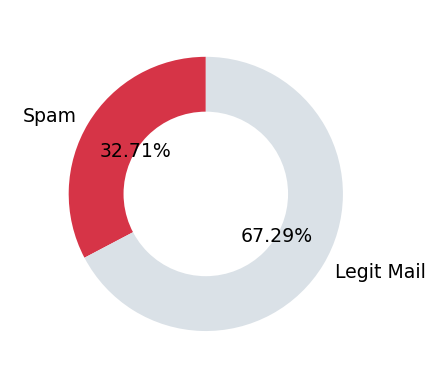

In [86]:
# Pie / Donut Chart Plotting

# chart parameters
category_names = ['Spam', 'Legit Mail']
sizes = [amount_spam, amount_not_spam]
custom_colours = ['#D63447','#DAE1E7']


plt.figure(figsize=(2, 2), dpi=227) # 227 density of pixels per inch
plt.pie(sizes, 
        labels=category_names, 
        textprops={'fontsize': 6}, 
        startangle=90, autopct='%1.2f%%', 
        colors=custom_colours
        #explode=[0, 0.1] >> this offsert separe our pie!
       ) # startangle --> Rotate our start angle for better visualization / autopct --> add automatically % / 

# Let's draw a Donut chart given our Pie Chart!
centre_circle = plt.Circle((0,0), radius= 0.6, fc='white') #xy tuple coordinate / radius / colour
plt.gca().add_artist(centre_circle)

plt.show()

## **Step 4: NPL - Natural Language Processing**

NPL is often used for Google Search, Personal Assistants (Siri, Alexia), Sentiment Analysis, Tweets, Google Ad Words, Autocorrection, Spell check, Translating...

NLTK is a python package that will help us with many functions for natural language processing.

We will follow the steps below to pre-process our data:

1. **Lower Case treatment**: Forcefully converts all string to lower case and prevent user incorrect inputs.
2. **Tokenising**: Split words individually
3. **Stop Words removal**: Exclude articles, conjunctions etc. (Example: 'the', 'to')
4. **Stemming**: Transforms a word to it's stem format (Example: Going / Goes = Go)
5. **Punctuation treatment**: Exclude commas, exclamation, periods etc.
6. **HTML tags removal**: Given our scenario, some e-mails may contain HTML tags that will cause noise for our data

**Notice**: This steps are used for ML purposes. Depending on what is your problem you will need another strategy!

Let's start with examples from our steps

In [87]:
msg = 'All work And no PlaY makes JacK a DULL BOY'

nltk.download('punkt') # Download multiple tokenizer tools in a folder 

# Transforming to lower case
word_tokenize(msg.lower())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

In [88]:
# Removing Stop Words >> Conjunctions, Linkings 
# Example: which, at, on, in, the, what etc... This is good for grammar but it's not useful for ML

nltk.download('stopwords') # Download the stop word tools for multiple languages and strategies.

# Set data structure: This data structure will be helpful in this type of problem, given it's efficiency on searching!
# Set >> It is an ordered, unidexed set of items!

# Load english stop words in a set
stop_words = set(stopwords.words('english'))

# Example >> Check the stop word
if 'this' in stop_words:
    
    print('found!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
found!


In [89]:
# Lowering Cases + Tokenising + Removing stop words

msg = 'All work and no Play makes Jack a DULL BOY.'

words = word_tokenize(msg.lower()) # tokenising and lowering case

stop_words = set(stopwords.words('english')) # load english stop words in a set

filtered_words = [] # Saves the list without stop words

for word in words: # for each word in our message..
    
    if word not in stop_words: # Check if the word is not a stop word...
        
        filtered_words.append(word) # Append the result

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy', '.']


In [90]:
# Word Stemming + Removing Punctuations

# Stemming >> Transform the word into its natural form. (Goes / Going >> Go)

# Porter Stemmer >> Default stemmer algorithm for English Language
# SnowballStemmer >> Another version for stemming with good efficiency!

# Removing Punctuation >> There is a native function called .isalpha() that returns False if it is a punctuation mark.


# Let's apply stemming + punctuations treatment on our previous NPL techniques

#stemmer = PorterStemmer() --> By default is english
stemmer = SnowballStemmer('english') # English language stemmer

msg = 'All work and no play makes Jack a dull boy. To be or Not to Be. \
        Nobody expects the Spanish Inquisition'

words = word_tokenize(msg.lower()) # tokenising and lowering case

stop_words = set(stopwords.words('english')) # load english stop words in a set

filtered_words = [] # Saves the list without stop words

for word in words: # for each word in our message..
    
    if word not in stop_words and word.isalpha(): # Check if the word is not a stop word and remove punctuation...

        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word) # Append the result

print(filtered_words) # With Stemmer! ['work', 'play', 'make', 'jack', 'dull', 'boy', '.']



['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


In [91]:
data.Message

Doc_ID
0       <html>\n\n<head>\n\n<title>Digital Publishing ...
1       Email marketing works!  There's no way around ...
2       =================================\n\n\n\nGuara...
3       <html>\n\n<body>\n\n<p>Do you like Sexy Animal...
4       <html>\n\n<head>\n\n<title>Cell Booster Antenn...
                              ...                        
5792    On Fri, Jul 19, 2002 at 03:35:36PM +0100 or so...
5793      | Date: Wed, 31 Jul 2002 15:13:23 +0100\n\n ...
5794    gcc, glibc and binutils, which the lfs site sa...
5795    --==_Exmh_-2079003886P\n\nContent-Type: text/p...
5796    On Sat, Jul 27, 2002 at 03:06:15PM +0100, Step...
Name: Message, Length: 5797, dtype: object

In [92]:
# Removing HTML Tags from email body

# We will use the BeautifulSoup html.parser as a controller to remove our HTML tags
soup = BeautifulSoup(data.at[2,'Message'], 'html.parser') # Text we would like to pass, Our parser

print(soup.prettify()) # Brings the message in a better way

# Removing HTML tags by getting only text!
soup.get_text()




Guaranteed to increase, lift and firm your

breasts in 60 days or your money back!!



100% herbal and natural.  Proven formula since 

1996.  Increase  your bust by 1 to 3 sizes within 30-60 

days and be all natural.  



Click here:

http://202.101.163.34:81/li/wangxd/



Absolutely no side effects!

Be more self confident!

Be more comfortable in bed!

No more need for a lift or support bra!



100% GUARANTEED AND FROM A NAME YOU KNOW AND 

TRUST!





**************************************************



You are receiving this email as a double opt-in 

subscriber to the Standard Affiliates Mailing 

List. 

To remove yourself from all related email lists,

just click here:

http://64.123.160.91:81/li/gg/unsubscriber.asp?userid=zzzz@netcomuk.co.uk



'=================================\n\n\n\nGuaranteed to increase, lift and firm your\n\nbreasts in 60 days or your money back!!\n\n\n\n100% herbal and natural.  Proven formula since \n\n1996.  Increase  your bust by 1 to 3 sizes within 30-60 \n\ndays and be all natural.  \n\n\n\nClick here:\n\nhttp://202.101.163.34:81/li/wangxd/\n\n\n\nAbsolutely no side effects!\n\nBe more self confident!\n\nBe more comfortable in bed!\n\nNo more need for a lift or support bra!\n\n\n\n100% GUARANTEED AND FROM A NAME YOU KNOW AND \n\nTRUST!\n\n\n\n\n\n**************************************************\n\n\n\nYou are receiving this email as a double opt-in \n\nsubscriber to the Standard Affiliates Mailing \n\nList. \n\nTo remove yourself from all related email lists,\n\njust click here:\n\nhttp://64.123.160.91:81/li/gg/unsubscriber.asp?userid=zzzz@netcomuk.co.uk\n\n\n'

Now, let's apply all these techniques to our Data Frame!

In [93]:
# NPL function for e-mail text pre-processing 
def clean_message(message, stemmer=PorterStemmer(), stop_words= set(stopwords.words('english'))):

  filtered_words = [] # our final list

  # 1. Remove HTML Tags
  soup = BeautifulSoup(message,'html.parser')
  cleaned_text = soup.get_text()

  # 2. Tokenize and convert to lower case
  words = word_tokenize(cleaned_text.lower())

  # 3. Remove stop words, punctuations and Stemming the word list for each word in our message
  # for each word in our message
  for word in words:

    # Remove stop words and punctuations
    if word not in stop_words and word.isalpha():

      # Stemming our word + Append in our final list
      filtered_words.append(stemmer.stem(word))

  return filtered_words

Now let's apply these NPL techniques to our email dataframe

Before we start, we will learn **how to slice dataframes and series & create subsets** in order to make our work easier.

In [94]:
# Slicing dataframes and series & Creating subsets

# Slicing >> .iloc[start:stop] Selects more than 1 row sequentially
data.iloc[0:2] # Select the first two rows (0 to 2)
data.iloc[5:11] # Select the rows from 5 to 11 (5 to 10)

first_emails = data.Message.iloc[0:3] # You can specify the column

# Apply function >> apply some function to a dataset. In this case we are applying clean_message function to first_emails dataset
nested_list = first_emails.apply(clean_message)

nested_list

Doc_ID
0    [digit, publish, tool, free, softwar, alert, p...
1    [email, market, work, way, around, medium, let...
2    [guarante, increas, lift, firm, breast, day, m...
Name: Message, dtype: object

In [95]:
# Generating all emails in a single list (flattened list)

# Solution 1: Traditional form (2x loops + append)
#for sublist in nested_list:
#  for item in sublist:
#    flat_list.append(item)

# Solution 2: Using list comprehension syntax (1 line of code, not so readable)
flat_list = [item for sublist in nested_list for item in sublist]

In [96]:
# Apply our NPL functions to our Dataframe
messages_list = data.Message.apply(clean_message)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [100]:
# Slicing data frames using logic

# We will create a new dataset with the condition into the []
docs_id_spam = data[data.Category == 1].index
docs_id_ham = data[data.Category == 0].index


# We can retrieved specific indexes with the 'loc' function
nested_list_spam = messages_list.loc[docs_id_spam]
nested_list_ham = messages_list.loc[docs_id_ham]

print('Nested list spam shape:',nested_list_spam.shape)
print('Nested list ham shape: ', nested_list_ham.shape)


Nested list spam shape: (1896,)
Nested list ham shape:  (3901,)


Now, Let's check which are the most common words in our dataset. This will be helpful in order to select the most frequent words for spam and not spam emails

In [102]:
# Checking the most common words in our NOT spam set of words
flat_list_ham = [item for sublist in nested_list_ham for item in sublist] # retrieve all data
normal_words = pd.Series(flat_list_ham).value_counts() # Create a Panda Series with our list and remove duplicates with value_counts

normal_words.shape[0] # total number of words witout duplications >> 20.815

normal_words[:10]

http      7562
use       3632
list      2878
one       2371
get       2286
mail      2255
would     2003
like      1929
messag    1847
work      1798
dtype: int64

In [103]:
# Checking the most common words in our spam set of words
flat_list_spam = [item for sublist in nested_list_spam for item in sublist] # retrieve all data
spam_words = pd.Series(flat_list_spam).value_counts() # Create a Panda Series with our list and remove duplicates with value_counts

print(spam_words.shape[0]) # total number of words witout duplications >> 13.242

spam_words[:10]

13280


http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## **Step 5: Creating the vocabulary and dictionary for our spam classifier**

Finishing our text pre-processing. There are lots of individual words among the 5.800 odd emails our dataset. We won't use every single word from the email body, we will use an amount of most frequent words (2.500 in our case).

In [104]:
# Generating the Vocabulary from our stemmed words
stemmed_nested_list = data.Message.apply(clean_message)

# Flatten the stemmed list 
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

# Get the unique list of words
unique_words = pd.Series(flat_stemmed_list).value_counts()

print('Nr of unique words:', unique_words.shape[0]) 

unique_words.head()

frequent_words = unique_words[0:VOCAB_SIZE] # Get the most 2.500 frequent words [begin:end] if not declared is = 0
print('Most common 10 words: \n', frequent_words[:10])

# Creating a vocabulary Data Frame with a WORD_ID

word_ids = list(range(0,VOCAB_SIZE))

vocabulary = pd.DataFrame({'Vocab_Words': frequent_words.index.values}, index= word_ids) #index.values >> get the values from the Series
vocabulary.index.name = 'Word_ID'

vocabulary.head()

# Saving our word list as CSV
vocabulary.to_csv(WORD_ID_FILE, index_label=vocabulary.index.name, header=vocabulary.Vocab_Words.name)



/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Nr of unique words: 27294
Most common 10 words: 
 http     10663
use       5019
list      4852
email     4370
get       4189
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


Practicing the techniques we have learnt

In [106]:
## Exercise 1: Check if a word is part of the vocabulary

any(vocabulary.Vocab_Words == 'http') # inefficient

# Convert our Data frame to a set to become more efficient!
print('http' in set(vocabulary.Vocab_Words))


## Exercise 2: Print out the number of words in the longest email (after cleaning & stemming)
# Note the longest email's position in the list of cleaned emails. Print out the stemmed list of the words from the data frame

clean_email_lengths = [] # number of character in each email

for sublist in stemmed_nested_list:
    
    clean_email_lengths.append(len(sublist))
    
# Alternatively with list comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]

print('Number of words in the longest email: ', max(clean_email_lengths))
print('Email position in the list and the dataframe: ', np.argmax(clean_email_lengths)) # Returns the location in the largest value

True
Number of words in the longest email:  7661
Email position in the list and the dataframe:  4815


In [107]:
stemmed_nested_list[np.argmax(clean_email_lengths)] # Collects the index from the biggest value

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

## **Step 6: Sparse Matrix** 

This is an excellend data structure for Machine Learning data frames

With this sort of Matrix we will exclude zeroed data. In our example, we will use words that occurs in spam / not spam emails, acting like a compressed version

In our example, each word will be placed with a label if it is spam or not and some level of occurence, and some words are zeros.

In [108]:
type(stemmed_nested_list[2]) # It is a DF with multiple lists in each index.

list

In [109]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.to_list()) # Transforming each word in a column as individual data point
word_columns_df.head()

# Df Shape: 5796 (emails that we have) x 7671 (number of words in the longest email)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
0,digit,publish,tool,free,softwar,alert,publish,like,profession,digit,publish,tool,easili,creat,profession,ebook,ebrochur,ecatalog,resum,newslett,present,magazin,photo,album,invit,much,much,save,money,save,tree,save,print,postag,advertis,cost,digit,publish,tool,download,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,email,market,work,way,around,medium,let,share,offer,peopl,less,cost,small,classifi,ad,get,access,target,email,list,exchang,member,exchang,old,target,email,list,new,one,get,access,million,fresh,gener,email,everi,week,offer,servic,free,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,guarante,increas,lift,firm,breast,day,money,back,herbal,natur,proven,formula,sinc,increas,bust,size,within,day,natur,click,http,absolut,side,effect,self,confid,comfort,bed,need,lift,support,bra,guarante,name,know,trust,receiv,email,doubl,subscrib,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,like,sexi,anim,wild,thing,super,hot,content,internet,site,heard,rate,number,one,adult,site,three,year,row,thousand,pic,hardcor,fuck,cum,shot,pet,girl,thousand,video,wait,click,must,least,enter,receiv,advertis,opt,receiv,free,adult,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,cell,booster,antenna,boost,recept,cell,phone,cordless,clariti,buy,anoth,phone,bad,recepiton,improv,commun,instantli,simpli,instal,small,chip,power,recept,booster,save,seen,product,compar,transpar,instal,second,power,antenna,drop,interrupt,call,work,place,singal,may,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [112]:
# Splitting the data into a training and testing data set

# Important: We will shuffle our DF in order to create this subsets
# Important 2: Try to use Validation + Test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.Category, test_size= 0.3, random_state= 42) # random state = seed value


In [113]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7621,7622,7623,7624,7625,7626,7627,7628,7629,7630,7631,7632,7633,7634,7635,7636,7637,7638,7639,7640,7641,7642,7643,7644,7645,7646,7647,7648,7649,7650,7651,7652,7653,7654,7655,7656,7657,7658,7659,7660
DOC_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2890,mon,sep,rick,rick,baartman,wrote,rick,danger,rememb,rick,folder,enter,safeguard,nope,regener,cach,script,f,echo,sort,f,sortm,f,scan,done,hal,mail,list,http,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5070,adam,beberg,write,interestingli,vc,convinc,zope,go,opensourc,wasnt,realiz,open,sourc,tm,ment,couldnt,control,go,assum,stupid,assum,still,stupid,never,realiz,karl,anderson,kra,http,http,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1293,thought,order,mortgat,loan,offic,graduat,colleg,certifi,licens,bond,think,messag,come,result,relationship,client,simpli,wish,remov,futur,messag,click,kj,h,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4355,think,articl,confus,social,bureaucraci,libertarian,implement,north,america,exactli,shine,pinnacl,econom,effici,tri,start,telephon,compani,us,even,wors,canada,take,year,get,bless,permit,raj,fcc,puc,ptt,decidedli,socialist,lean,canada,industri,canada,crtc,yet,despit,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4845,mean,like,mac,keyboard,microsoft,usb,keyboard,ms,internet,pro,unit,two,port,hub,consid,use,flash,unit,one,storag,key,unfortun,kvm,switch,would,drive,client,program,crazi,switch,machin,kearney,http,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [114]:
y_train.head() # Note that our DOC_ID matches between X and y datasets

Doc_ID
2890    0
5070    0
1293    1
4355    0
4845    0
Name: Category, dtype: int64

In [115]:
# Creating the Sparse Matrix

# Create a particular index given a  DataFrame
word_index = pd.Index(vocabulary.Vocab_Words)

type(word_index)

pandas.core.indexes.base.Index

In [116]:
# Let's create our function to process

def create_sparse_matrix(df, indexed_words, labels): # Data Frame, Index Words + y values
    
    """
    Returns spare matrix as dataframe
    
    df: A dataframe with words in the columns with a document id (Doc_Id) as an index (X_train or X_test).
    indexed_words
    
    indexed_words: Index of words by word id (Word_Id)
    
    labels: Category as a series (y_train or y_test).
    
    """
    
    # Control variables
    nr_rows = df.shape[0]
    nr_columns = df.shape[1]
    word_set = set(indexed_words) # create a python set from our indexed_words
    dict_list = [] # Creates an empty dictionary
    
    # Loop through df
    for i in range(nr_rows):
        for j in range(nr_columns):
            
            word = df.iat[i , j]
            
            if word in word_set:
                
                doc_id = df.index[i] # Get the Doc_Id
                word_id = indexed_words.get_loc(word) # Get the Word_Id
                category = labels.at[doc_id] # Get the category (Spam / Not Spam)
                
                # Create the item dictionary and append to our list
                item= {'LABEL': category, 
                       'DOC_ID': doc_id, 
                       'OCCURRENCE': 1, 
                       'WORD_ID': word_id}
                
                dict_list.append(item)
            
    
    return pd.DataFrame(dict_list)

In [117]:
# Let's run our function
sparse_train_df = create_sparse_matrix(X_train, word_index, y_train)

# If we take a peek at our Sparse Data Frame we will find that if we have the same word in the email, it is duplicated. So we need to group by 
sparse_train_df[-5:]  # last 5 rows

,LABEL,DOC_ID,OCCURRENCE,WORD_ID
438615,0,5390,1,181
438616,1,860,1,10
438617,1,860,1,438
438618,1,860,1,297
438619,1,860,1,0


In [118]:
# Combining occurencies with the Pandas groupby() method
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum() # Group by that keys and sum up the occurencies

train_grouped.head()

OCCURRENCE
DOC_ID WORD_ID LABEL            
0      2       1               1
       5       1               1
       7       1               4
       8       1               2
       12      1               1

In [120]:
# Will make our doc id for every single row and not summarized
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,0,2,1,1
1,0,5,1,1
2,0,7,1,4
3,0,8,1,2
4,0,12,1,1


In [122]:
# Saving our work (as .txt)
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d') # Relative Path , Data to be saved, and format

In [ ]:
# Creating a spare matrix for our test dataframe

# Create the sparse matrix
sparse_test_df = create_sparse_matrix(X_test, word_index, y_test)

# Group our data by 3 columns summing up our Occurencies
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

# Add the Doc_Id for each row (Reseting the index)
test_grouped = train_grouped.reset_index()

# Saving our grouped test (as .txt)
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d') # Relative Path , Data to be saved, and format

In [ ]:
# Checking our text pre-processing

# We started with 5.796 emails, and then splitted in 4.057 and 1.739 for testing. Are the number equal to our .txt?
# How many individual emails were included in the testing file?

# Check our Document IDs 
train_doc_ids = set(train_grouped.DOC_ID) # 4.014 vs 4.057 
test_doc_ids = set(test_grouped.DOC_ID) # 1.723  vs 1.739

# Why some emails were excluded? Which were the emails?

# 1st let's compare the sets
set(X_test.index.values) - test_doc_ids

## Extra Topic: Word Cloud charts

It's not scientific but it's beautiful! and grabs people's attention

